In [ ]:
from google.colab import drive
import os
import shutil
import librosa
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
from scipy.signal import butter, lfilter
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import random
from collections import Counter


In [ ]:
# Step 1: Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 2: Set dataset path
dataset_path = '/content/drive/My Drive/dataset'
output_dir = '/content/processed_audio'

# Step 3: Prepare output directory
shutil.rmtree(output_dir, ignore_errors=True)
os.makedirs(output_dir, exist_ok=True)

# List of speaker folders
speaker_folders = ['Anuj_Shrestha', 'Ekata_Adhikari','Varsha_Madhikarmy','Asim_Shrestha']
num_files_to_augment = 1500

In [ ]:
# Function to apply a low-pass filter to remove noise
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.8 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order)
    y = lfilter(b, a, data)
    return y

In [ ]:
# Block 5: Process Dataset
for speaker_folder in speaker_folders:
    speaker_path = os.path.join(dataset_path, speaker_folder)
    audio_data = []

    for i in range(1, 100):  # Assuming files are named 1.wav, 2.wav, ...
        file_path = os.path.join(speaker_path, f"{i}.wav")
        if os.path.exists(file_path):
            audio, sr = librosa.load(file_path, sr=None)
            audio = butter_lowpass_filter(audio, cutoff=4000, fs=sr)  # Remove noise
            audio_data.append(audio)

    combined_audio = np.concatenate(audio_data)

    # Augment to reach 1000 samples
    for i in range(1, num_files_to_augment + 1):
        start = (i * sr) % len(combined_audio)
        augmented_audio = combined_audio[start:start + sr]
        output_path = os.path.join(output_dir, f"{speaker_folder}_{i}.wav")
        sf.write(output_path, augmented_audio, sr)

  # Count the number of files per speaker in the augmented dataset
from collections import Counter

file_counts = Counter()
for file in os.listdir(output_dir):
    speaker_name = "_".join(file.split("_")[:-1])  # Extract speaker name
    file_counts[speaker_name] += 1

# Print file counts for each speaker
for speaker, count in file_counts.items():
    print(f"Speaker {speaker}: {count} files")

Speaker Asim_Shrestha: 1500 files
Speaker Ekata_Adhikari: 1500 files
Speaker Anuj_Shrestha: 1500 files
Speaker Varsha_Madhikarmy: 1500 files


<ipython-input-43-8ba80c7c3734>:17: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


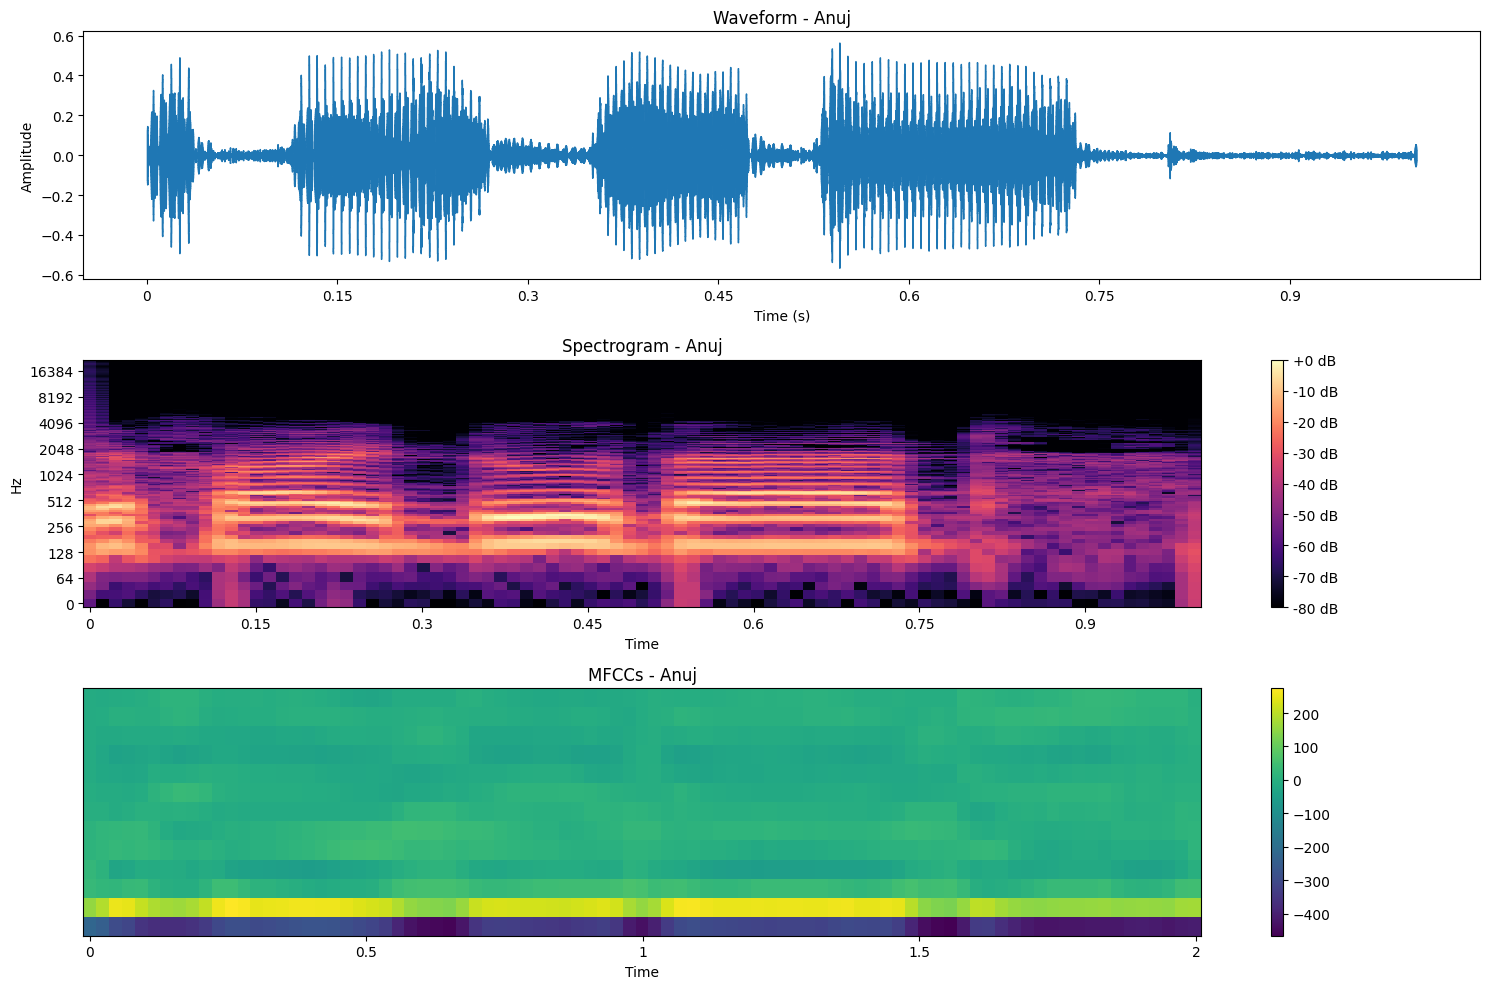

In [ ]:

   # Function to plot audio features
def plot_audio_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    speaker_name = os.path.basename(audio_path).split('_')[0]

    plt.figure(figsize=(15, 10))

    # Plot Waveform
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform - {speaker_name}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Plot Spectrogram
    plt.subplot(3, 1, 2)
    D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram - {speaker_name}')

    # Plot MFCCs
    plt.subplot(3, 1, 3)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    librosa.display.specshow(mfccs, x_axis='time', cmap='viridis')
    plt.colorbar()
    plt.title(f'MFCCs - {speaker_name}')

    plt.tight_layout()
    plt.show()

# Example: Plot features of a random audio sample
example_audio = random.choice(os.listdir(output_dir))
plot_audio_features(os.path.join(output_dir, example_audio))

In [ ]:
# Set dataset path inside Google Drive
parent_dir = "/content/drive/My Drive/dataset"

# List of speaker folders
speaker_folders = [
    "Anuj_Shrestha",
    "Ekata_Adhikari",
    "Varsha_Madhikarmy",
    "Asim_Shrestha"
]

# Set a fixed MFCC sequence length (adjust based on dataset)
fixed_length = 50  # Number of time steps

# Function to extract MFCC features
def extract_features(parent_dir, speaker_folders, duration=1):
    features = []
    labels = []

    for speaker in speaker_folders:
        speaker_path = os.path.join(parent_dir, speaker)

        for filename in os.listdir(speaker_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(speaker_path, filename)
                audio, sr = librosa.load(file_path, sr=None, duration=duration)
                mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=8)

                # Normalize MFCC features
                mfccs = StandardScaler().fit_transform(mfccs)

                # Transpose MFCCs (time steps, features)
                mfccs = mfccs.T

                # Pad or truncate to fixed_length
                mfccs = pad_sequences([mfccs], maxlen=fixed_length, padding='post', truncating='post', dtype='float32')[0]

                features.append(mfccs)
                labels.append(speaker_folders.index(speaker))

    return np.array(features), np.array(labels)

# Extract features and labels
X, y = extract_features(parent_dir, speaker_folders)

print(f"Feature Shape: {X.shape}")  # Expected: (num_samples, fixed_length, n_mfcc)
print(f"Labels Shape: {y.shape}")



Feature Shape: (4349, 50, 8)
Labels Shape: (4349,)


In [ ]:
 #Print the first few features
for feature in X[:1]:
    print(feature)

[[-2.497422    1.161931    0.36817953  0.40652007  0.27467397  0.17177536
   0.0729005   0.04144164]
 [-2.5054994   1.1308464   0.34738398  0.4602662   0.2755559   0.16490686
   0.06525455  0.06128538]
 [-2.5472875   0.98083943  0.43410707  0.4656717   0.31658202  0.15407923
   0.07791664  0.1180914 ]
 [-2.5530276   0.9718423   0.36687857  0.4690971   0.35974833  0.17459475
   0.08561119  0.12525538]
 [-2.5536828   0.95580673  0.31867215  0.45969042  0.44045973  0.20836712
   0.07348396  0.09720279]
 [-2.5461462   0.9856728   0.29148117  0.45278698  0.44575667  0.20480748
   0.05784832  0.10779291]
 [-2.5355208   1.0191929   0.28328902  0.47204643  0.42145434  0.2028599
   0.04400739  0.09267077]
 [-2.5147111   1.0945945   0.28221363  0.44001594  0.37623277  0.24573888
   0.03551892  0.04039652]
 [-2.4751952   1.2335228   0.29351822  0.3464476   0.30242532  0.22268629
   0.06717417  0.0094209 ]
 [-2.4401286   1.3368636   0.31441566  0.2368857   0.23446505  0.18857384
   0.11320666  0.0

In [ ]:
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(speaker_folders))
y_val = tf.keras.utils.to_categorical(y_val, num_classes=len(speaker_folders))


Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step - accuracy: 0.3874 - loss: 1.3270 - val_accuracy: 0.3712 - val_loss: 1.4537
Epoch 2/4
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.5806 - loss: 1.0742 - val_accuracy: 0.6672 - val_loss: 0.9207
Epoch 3/4
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.6988 - loss: 0.8843 - val_accuracy: 0.7638 - val_loss: 0.8297
Epoch 4/4
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.7564 - loss: 0.7750 - val_accuracy: 0.6534 - val_loss: 1.0070
Training completed without early stopping


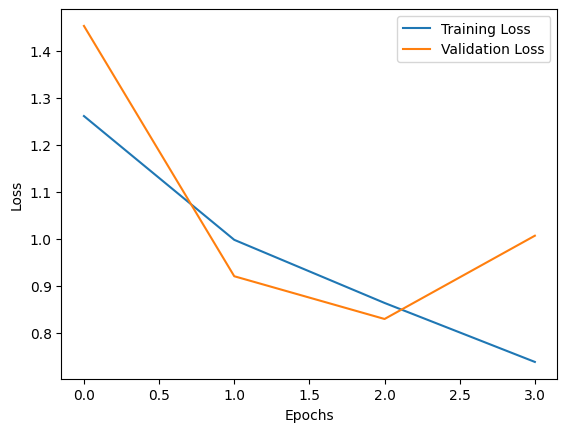

In [ ]:
# Define the RNN model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(speaker_folders), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.08),  # Further increase label smoothing
    metrics=['accuracy']
)


# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=4, batch_size=32, callbacks=[early_stopping])

# Check if EarlyStopping triggered
if early_stopping.stopped_epoch > 0:
    print("Early stopping triggered at epoch", early_stopping.stopped_epoch + 1)
else:
    print("Training completed without early stopping")

# Plot training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Test Accuracy: 0.7642
Weighted F1 Score: 0.7634


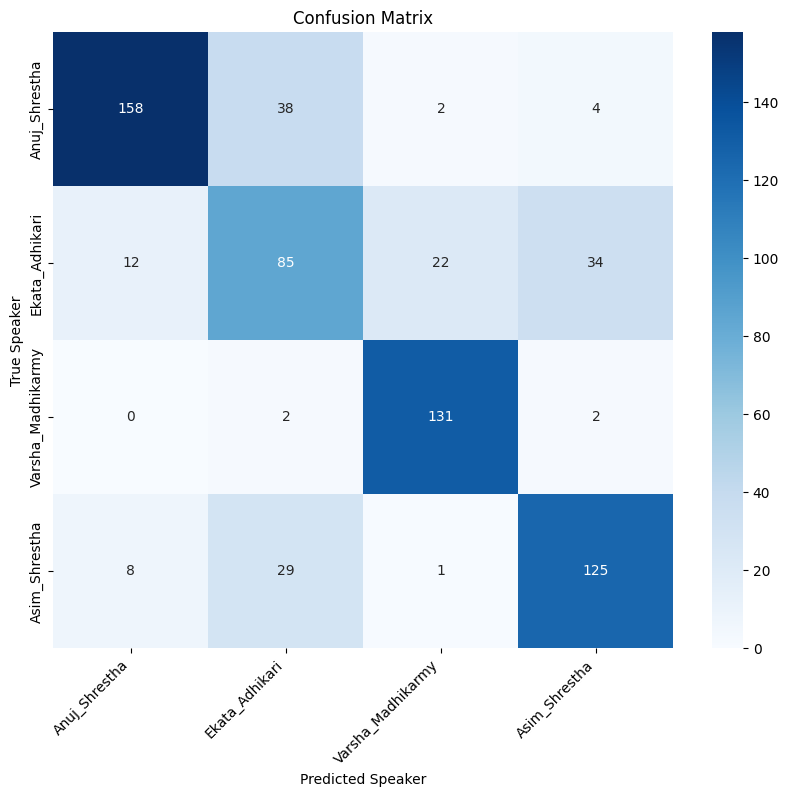

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# List of speaker names
speaker_names = [ 'Anuj_Shrestha', 'Ekata_Adhikari', 'Varsha_Madhikarmy', 'Asim_Shrestha']

# Ensure the model is defined before proceeding
try:
    y_pred_probabilities = model.predict(X_test)
except NameError:
    raise NameError("Error: The model is not defined. Please train or load the model before making predictions.")

# Get predicted class labels
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Map numeric labels to speaker names
y_test_named = [speaker_names[label] for label in y_test]
y_pred_named = [speaker_names[label] for label in y_pred]

# Get unique speaker names to ensure correct label ordering
unique_speakers = speaker_names

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_named, y_pred_named, labels=unique_speakers)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_named, y_pred_named)
f1 = f1_score(y_test_named, y_pred_named, labels=unique_speakers, average='weighted')

# Print results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")

# Plot confusion matrix with speaker names
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=unique_speakers, yticklabels=unique_speakers)

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Speaker")
plt.ylabel("True Speaker")
plt.show()




In [ ]:
import librosa
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler

# Function to extract key audio features
def extract_audio_features(audio_path):
    y, sr = librosa.load(audio_path, sr=22050, mono=True)  # Force mono and standard sampling rate

    # Adjust MFCCs to match model input shape (using only 8 MFCCs instead of 13)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=8)
    mfccs = StandardScaler().fit_transform(mfccs).T
    mfccs_padded = pad_sequences([mfccs], maxlen=50, padding='post', dtype='float32')[0]

    # Debugging shape
    print(f"Extracted MFCC shape: {mfccs_padded.shape}")  # Should be (50, 8)

    # Pitch (Fundamental Frequency - F0)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_values = pitches[pitches > 0]
    avg_pitch = np.mean(pitch_values) if pitch_values.size > 0 else 0

    # Loudness (Root Mean Square Energy - RMSE)
    rmse = np.mean(librosa.feature.rms(y=y))

    return mfccs_padded, avg_pitch, rmse

# Function to predict speaker and compare features
def predict_speaker(audio_path, model, speaker_folders):
    # Extract features from input audio
    mfccs_padded, input_pitch, input_loudness = extract_audio_features(audio_path)

    # Reshape for model input (Ensure it matches model.input_shape)
    input_audio = np.expand_dims(mfccs_padded, axis=0)  # Shape should be (1, 50, 8)

    # Check model input shape
    print(f"Model expected input shape: {model.input_shape}")
    print(f"Actual input shape: {input_audio.shape}")

    # Predict speaker using model
    predictions = model.predict(input_audio)
    pred_idx = np.argmax(predictions)
    predicted_speaker = speaker_folders[pred_idx]

    # Compute similarity percentages for all speakers
    similarities = {speaker_folders[i]: round(predictions[0][i] * 100, 2) for i in range(len(speaker_folders))}

    # Sort similarities in descending order
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

    # Display prediction results
    print(f"\n **Predicted Speaker:** {predicted_speaker}")
    print(f" **Confidence:** {similarities[predicted_speaker]}% match")

    print("\n **Resemblance with Other Speakers:**")
    for speaker, confidence in sorted_similarities:
        if speaker != predicted_speaker:
            print(f"   - {speaker}: {confidence}% similarity")

# Example usage (Ensure 'model' and 'speaker_folders' are defined before running this)
test_audio_path = "/content/drive/My Drive/try/try.wav"
predict_speaker(test_audio_path, model, speaker_folders)



<ipython-input-12-d53d67693d66>:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=22050, mono=True)  # Force mono and standard sampling rate
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracted MFCC shape: (50, 8)
Model expected input shape: (None, 50, 8)
Actual input shape: (1, 50, 8)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

🎙 **Predicted Speaker:** Anuj_Shrestha
✅ **Confidence:** 41.17% match

🔎 **Resemblance with Other Speakers:**
   - Varsha_Madhikarmy: 24.87% similarity
   - Ekata_Adhikari: 18.86% similarity
   - Asim_Shrestha: 15.1% similarity


In [ ]:
import librosa
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler

def extract_audio_features(audio_path):
    y, sr = librosa.load(audio_path, sr=22050, mono=True)

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=8)
    mfccs = StandardScaler().fit_transform(mfccs).T
    mfccs_padded = pad_sequences([mfccs], maxlen=50, padding='post', dtype='float32')[0]

    # Extract pitch (Fundamental Frequency - F0)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_values = pitches[pitches > 0]
    avg_pitch = np.mean(pitch_values) if pitch_values.size > 0 else 0

    # Extract loudness (Root Mean Square Energy - RMSE)
    rmse = np.mean(librosa.feature.rms(y=y))

    return mfccs_padded, avg_pitch, rmse

def predict_best_match(audio_path, model, speaker_data, speaker_folders):
    input_mfccs, input_pitch, input_loudness = extract_audio_features(audio_path)
    input_audio = np.expand_dims(input_mfccs, axis=0)

    # Predict speaker based on MFCC pattern
    predictions = model.predict(input_audio)
    best_match_idx = np.argmax(predictions)
    best_match_speaker = speaker_folders[best_match_idx]

    # Compute similarity percentages for pitch, pattern, and loudness
    similarities = {}
    for speaker, (mfccs, pitch, loudness) in speaker_data.items():
        pitch_similarity = 100 - abs(input_pitch - pitch) / (input_pitch + 1e-6) * 100
        loudness_similarity = 100 - abs(input_loudness - loudness) / (input_loudness + 1e-6) * 100
        pattern_similarity = round(predictions[0][speaker_folders.index(speaker)] * 100, 2)

        similarities[speaker] = {
            "Pitch": max(0, round(pitch_similarity, 2)),
            "Loudness": max(0, round(loudness_similarity, 2)),
            "Pattern": pattern_similarity
        }

    # Determine overall best match by averaging the three scores
    overall_best_speaker = max(similarities, key=lambda x: np.mean(list(similarities[x].values())))
    overall_best_score = round(np.mean(list(similarities[overall_best_speaker].values())), 2)

    # Display results
    print(f"\n Predicted Best Match: {overall_best_speaker} (Overall Similarity: {overall_best_score}%)\n")
    print(" Comparison with Other Speakers:")
    for speaker, scores in similarities.items():
        print(f"  - {speaker}:")
        print(f"     Pitch Similarity: {scores['Pitch']}%")
        print(f"     Pattern Similarity: {scores['Pattern']}%")
        print(f"     Loudness Similarity: {scores['Loudness']}%\n")

# Example usage:
test_audio_path = "/content/drive/My Drive/try/try.wav"
speaker_data = {  # Simulated data (Replace with actual extracted features)
    "Anuj_Shrestha": (None, 120, 0.05),
    "Ekata_Adhikari": (None, 130, 0.07),
    "Varsha_Madhikarmy": (None, 110, 0.06),
    "Asim_Shrestha": (None, 125, 0.08),
}

predict_best_match(test_audio_path, model, speaker_data, speaker_folders)

<ipython-input-13-d284a5c879c1>:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=22050, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

✅ Predicted Best Match: Anuj_Shrestha (Overall Similarity: 17.37%)

🔎 Comparison with Other Speakers:
  - Anuj_Shrestha:
    🎵 Pitch Similarity: 10.95%
    📈 Pattern Similarity: 41.17%
    🔊 Loudness Similarity: 0%

  - Ekata_Adhikari:
    🎵 Pitch Similarity: 11.87%
    📈 Pattern Similarity: 18.86%
    🔊 Loudness Similarity: 0%

  - Varsha_Madhikarmy:
    🎵 Pitch Similarity: 10.04%
    📈 Pattern Similarity: 24.87%
    🔊 Loudness Similarity: 0%

  - Asim_Shrestha:
    🎵 Pitch Similarity: 11.41%
    📈 Pattern Similarity: 15.1%
    🔊 Loudness Similarity: 0%



In [ ]:
import os
import librosa
import numpy as np
import random

# Set the dataset path and test file path
dataset_path = "/content/drive/My Drive/dataset"
test_file_path = "/content/drive/My Drive/try/try.wav"

# Function to extract MFCC, pitch, and amplitude features
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)

    # Extract MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)

    # Extract Pitch (Fundamental Frequency)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0

    # Extract Amplitude (Loudness)
    amplitude = np.mean(librosa.feature.rms(y=y))

    return mfcc_mean, pitch, amplitude

# Load dataset and extract features
def load_dataset(dataset_path):
    speakers = {}
    for speaker in os.listdir(dataset_path):
        speaker_path = os.path.join(dataset_path, speaker)
        if os.path.isdir(speaker_path):
            audio_files = [f for f in os.listdir(speaker_path) if f.endswith(".wav")]
            if audio_files:
                random_file = os.path.join(speaker_path, random.choice(audio_files))
                speakers[speaker] = extract_features(random_file)
    return speakers

# Compute cosine similarity
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Predict the speaker
def predict_speaker(test_file, dataset):
    test_mfcc, test_pitch, test_amplitude = extract_features(test_file)
    best_match = None
    best_score = -1
    feature_similarities = {}

    for speaker, (mfcc, pitch, amplitude) in dataset.items():
        mfcc_sim = cosine_similarity(test_mfcc, mfcc) * 100  # Convert to percentage
        pitch_sim = (1 - abs(test_pitch - pitch) / max(test_pitch, pitch)) * 100 if max(test_pitch, pitch) > 0 else 0
        amplitude_sim = (1 - abs(test_amplitude - amplitude) / max(test_amplitude, amplitude)) * 100 if max(test_amplitude, amplitude) > 0 else 0

        avg_similarity = (mfcc_sim + pitch_sim + amplitude_sim) / 3

        feature_similarities[speaker] = (mfcc_sim, pitch_sim, amplitude_sim, avg_similarity)

        if avg_similarity > best_score:
            best_score = avg_similarity
            best_match = speaker

    return best_match, best_score, feature_similarities

# Main execution
def main():
    print(" **Testing Sample from Try.wav:**")

    dataset = load_dataset(dataset_path)

    predicted_speaker, confidence, feature_similarities = predict_speaker(test_file_path, dataset)

    print(f"Predicted Speaker: {predicted_speaker} ({confidence:.2f}% match)\n")

    print(" **Feature Similarity Breakdown:**")
    for speaker, (mfcc_sim, pitch_sim, amp_sim, avg_sim) in feature_similarities.items():
        print(f" - {speaker}:")
        print(f"    MFCC (Pattern) Similarity: {mfcc_sim:.2f}%")
        print(f"    Pitch Similarity: {pitch_sim:.2f}%")
        print(f"    Loudness Similarity: {amp_sim:.2f}%\n")

if __name__ == "__main__":
    main()



🔊 **Testing Sample from Try.wav:**


<ipython-input-44-4be90e3f64a8>:12: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Predicted Speaker: Asim_Shrestha (81.03% match)

🔍 **Feature Similarity Breakdown:**
 - Varsha_Madhikarmy:
    MFCC (Pattern) Similarity: 96.94%
    Pitch Similarity: 68.18%
    Loudness Similarity: 48.04%

 - Anuj_Shrestha:
    MFCC (Pattern) Similarity: 95.73%
    Pitch Similarity: 65.24%
    Loudness Similarity: 22.63%

 - Asim_Shrestha:
    MFCC (Pattern) Similarity: 99.73%
    Pitch Similarity: 90.17%
    Loudness Similarity: 53.18%

 - Ekata_Adhikari:
    MFCC (Pattern) Similarity: 97.91%
    Pitch Similarity: 46.18%
    Loudness Similarity: 18.06%

